In [1]:
import numpy as np
from numpy import sin, pi, exp
import scipy.sparse as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
@np.vectorize
def exact(x, y, t, tol):
    #equation in the summation
    sum_func = lambda k, l: sin(pi*(1 + 2*k)*x) * sin(pi*(1 + 2*l)*y)\
                            / ((1 + 2*l)*(1 + 2*k)*((1 + 2*k)**2 + (1 + 2*l)**2))\
                            * (1 - exp(-pi**2*((1 + 2*k)**2 + (1 + 2*l)**2)*t))
    
    #initialize
    n = 0
    prev = 0
    summation = sum_func(0, 0)
    
    #iterate
    while abs(prev - summation) > tol:
        n+=1
        prev = summation
        for k in range(n+1):
            l = n - k
            summation += sum_func(k, l)
    
    #return "exact" solution
    return 16/pi**4 * summation

In [3]:
def ADI(n_x, n_y, dt, T):
    dx = 1/(n_x)
    dy = 1/(n_y)
    U = np.zeros((n_x-1, n_y-1))    #interior only
    
    #predictor step: P1 U_half = U P2
    P1 = sp.diags([-dt/2/dx**2, 1 + dt/dx**2, -dt/2/dx**2],
                  [-1, 0, 1], shape=(n_x-1, n_x-1)).todense()
    P2 = sp.diags([dt/2/dy**2, 1 - dt/dy**2, dt/2/dy**2], [-1, 0, 1],
                  shape=(n_y-1, n_y-1)).todense()

    #corrector step: U C1 = C2 U_half
    C1 = sp.diags([-dt/2/dy**2, 1 + dt/dy**2, -dt/2/dy**2],
                  [-1, 0, 1], shape=(n_y-1, n_y-1)).todense()
    C2 = sp.diags([dt/2/dx**2, 1 - dt/dx**2, dt/2/dx**2], [-1, 0, 1],
                  shape=(n_x-1, n_x-1)).todense()
    
    #iterate
    t = 0
    while t < T:
        t += dt
        
        #two half-steps
        U_half = np.linalg.solve(P1, (U @ P2) + dt/2)
        U = np.linalg.solve(C1.T, (C2 @ U_half).T + dt/2).T
        
    return np.pad(U, 1)    #pad with zeros since BC = 0

In [4]:
def grid_norm(A, order=2):
    if order == np.inf:
        return np.max(A)
    else:
        n = A.size
        return np.power(np.sum(np.power(np.abs(A), order)), (1/order)) / n

In [5]:
n_x, n_y, dt = 25, 30, .01
X, Y = np.meshgrid(np.linspace(0, 1, 1+n_y), np.linspace(0, 1, 1+n_x))

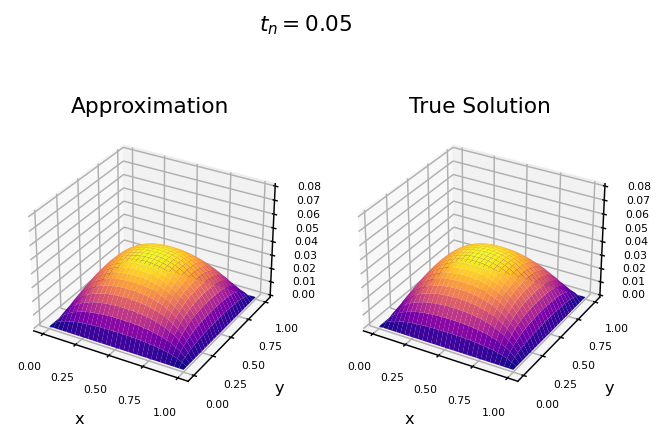

error = 1.4065751064221933e-06


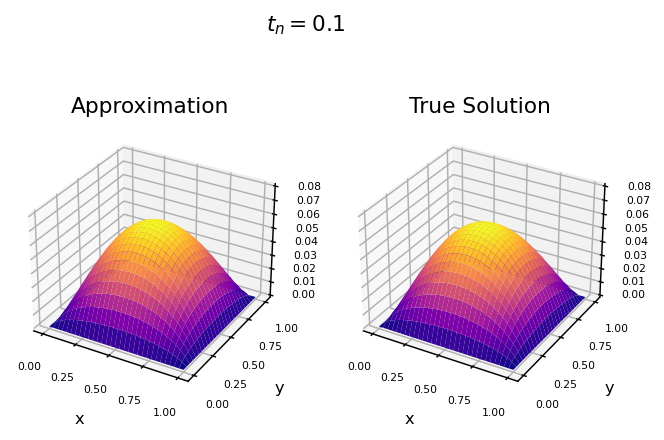

error = 3.325191258685493e-05


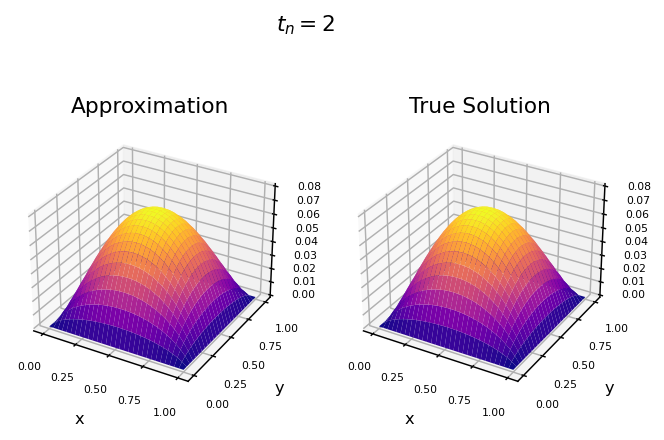

error = 1.7555698525595088e-06


In [6]:
for t in [.05, .1, 2]:
    #get approximation
    aprx = ADI(n_x, n_y, dt, t)
    
    #get true solution
    sol = exact(X, Y, t, 1e-5)
    
    #plot approximation
    fig = plt.figure(dpi=130)
    plt.suptitle(f'$t_n = {t}$')
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title('Approximation')
    ax.plot_surface(X, Y, aprx, cmap='plasma')
    plt.xlabel('x', size=9)
    plt.ylabel('y', size=9)
    plt.xticks(size=6)
    plt.yticks(size=6)
    ax.zaxis.set_tick_params(labelsize=6)
    ax.set_zlim(0, .08)
    
    #plot true solution
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_title('True Solution')
    ax.plot_surface(X, Y, sol, cmap='plasma')
    plt.xlabel('x', size=9)
    plt.ylabel('y', size=9)
    plt.xticks(size=6)
    plt.yticks(size=6)
    ax.zaxis.set_tick_params(labelsize=6)
    ax.set_zlim(0, .08)
    plt.show()
    
    #print error
    print('error =', grid_norm(aprx - sol))